In [1]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")  # Set the device to CUDA
    print("CUDA is available on:", device)
    print("Current CUDA device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(0))  # Get the name of the GPU
else:
    device = torch.device("cpu")  # Fallback to CPU if CUDA is not available
    print("CUDA is not available. Using CPU.")
    print("Current device:", device)

CUDA is available on: cuda
Current CUDA device: 0
Device name: NVIDIA GeForce GTX 1050 Ti


In [2]:
# Import libraries
import matplotlib.pyplot as plt
#%matplotlib.use('TkAgg')
import torch
from PIL import Image
from transformers import GLPNImageProcessor, GLPNForDepthEstimation

In [3]:
# Getting model

feature_extractor = GLPNImageProcessor.from_pretrained("vinvino02/glpn-nyu")
model = GLPNForDepthEstimation.from_pretrained("vinvino02/glpn-nyu")

In [4]:
# loading and resizing the image

image = Image.open(r"D:\input-1.jpg")

new_height = 480 if image.height > 480 else image.height
new_height -= (new_height % 32)
new_width = int(new_height * image.width / image.height)
diff = new_width % 32

new_width = new_width - diff if diff < 16 else new_width + 32 - diff
new_size = (new_width, new_height)
image = image.resize(new_size)

In [5]:
# Preparing the image for the model

inputs = feature_extractor(images=image, return_tensors="pt")

In [6]:
# Getting the prediction from the model

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

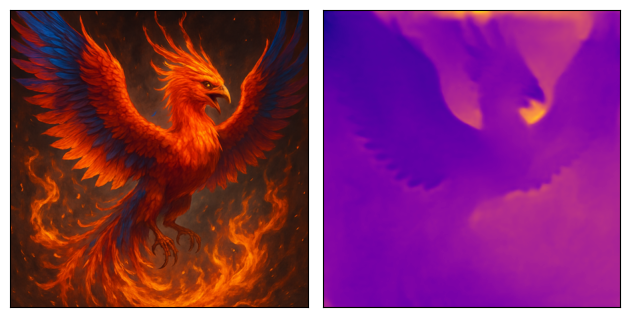

In [7]:
# Post-processing

pad = 16
output = predicted_depth.squeeze().cpu().numpy() * 1000.0
output = output[pad:-pad, pad:-pad]
image = image.crop((pad, pad, image.width - pad, image.height - pad))

fig, ax = plt.subplots(1, 2)
ax[0].imshow(image)
ax[0].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax[1].imshow(output, cmap='plasma')
ax[1].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.tight_layout()
plt.pause(5)

In [8]:
# importing the libraries
import numpy as np
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [9]:
# Preparing the depth image for open3d

width, height = image.size

depth_image = (output * 255 / np.max(output)).astype('uint8')
image = np.array(image)

# create rgbd image
depth_o3d = o3d.geometry.Image(depth_image)
image_o3d = o3d.geometry.Image(image)
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(image_o3d, depth_o3d, convert_rgb_to_intensity=False)


In [10]:
# Creating a Camera

camera_intrinsic = o3d.camera.PinholeCameraIntrinsic()
camera_intrinsic.set_intrinsics(width, height, 500, 500, width/2, height/2)

In [11]:
# Creating o3d point cloud

pcd_raw = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsic)

o3d.visualization.draw_geometries([pcd_raw])

In [12]:
# Post-processing the 3D Point Cloud

# Outliers removal
cl, ind = pcd_raw.remove_statistical_outlier(nb_neighbors=20, std_ratio=6.0)
pcd =pcd_raw.select_by_index(ind)

# estimate normals
pcd.estimate_normals()
pcd.orient_normals_to_align_with_direction()

o3d.visualization.draw_geometries([pcd])

In [13]:
# surface reconstruction

mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=10, n_threads=1)[0]

# Rotate the mesh
rotation = mesh.get_rotation_matrix_from_xyz((np.pi, 0, 0))
mesh.rotate(rotation, center=(0, 0, 0))

# Visualize the mesh
o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)

# mesh_uniform = mesh.paint_uniform_color([0.9, 0.8, 0.9])
# mesh_uniform.compute_vertex_normals()
# o3d.visualization.draw_geometries([mesh_uniform], mesh_show_back_face=True)

In [14]:
# 3D Mesh Export

#o3d.io.write_triangle_mesh('D/result.obj', mesh)